# CelebA Dataset

* site : http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

# DCGAN

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.preprocessing import LabelBinarizer

## Download & Load CelebA

In [2]:
import os
import sys
import urllib
import zipfile

In [3]:
SavePath = 'CelebA_data/'

##### Download

In [4]:
if not os.path.exists(SavePath):
    # Dropbox Link can be terminated
    link = 'https://www.dropbox.com/s/gxjc9p7s6xmo09k/CelebA_Align.zip?dl=1'
    url = urllib.request.urlopen(link)

    filesize = int(url.headers['Content-Length'])
    filename = 'CelebA_Align.zip'

    with open(filename, 'wb') as f:
        downloaded = 0
        block_size = 8192
        status_width = 70
        while True:
            buffer = url.read(block_size)
            if not buffer:
                break

            downloaded += len(buffer)
            f.write(buffer)
            status = (("[%-" + str(status_width + 1) + "s] %3.2f%%") %
              ('=' * int(downloaded / filesize * status_width) + '>', downloaded * 100 / filesize))
            display.clear_output(wait=True)
            print(status, end='')

    with zipfile.ZipFile(filename) as zf:
        print('\nExtracting %s ...' % filename)
        zf.extractall(SavePath)
        print('Done.')

    os.remove(filename)

##### Load

In [5]:
file_names = []
file_tags = []
with open(SavePath + 'list_attr_celeba.txt') as f:
    data_size = int(f.readline())
    tag_list = np.array(f.readline().split())
    
    for line in f.readlines():
        file_name, *tagging = line.split()
        file_names.append(file_name)
        file_tags.append((np.array(tagging).astype(int) == 1).astype(int))
        
    file_names = np.array(file_names)
    file_tags = np.array(file_tags)
    
file_size = len(file_names)

In [6]:
def image_load(name, width, height):
    img = Image.open(SavePath + 'img_align_celeba/' + name)
    img = img.resize((width, height), resample=Image.ANTIALIAS)
    pixel = np.array([x for x in img.getdata()])
    return pixel.reshape(width, height, 3)

In [7]:
loaded_set = {}
def batch_from_dataset(names, width, height):
    batch = []
    for name in names:
        if name not in loaded_set:
            loaded_set[name] = image_load(name, width, height)
        batch.append(loaded_set[name])
        
    return np.array(batch) / 255

## Function Implement

In [8]:
# Reference : https://github.com/GunhoChoi/LSGAN_TF/blob/master/LSGAN/LSGAN_TF.ipynb
def LeakyReLU(x, leak=0.2, name='LeakyReLU'):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

In [9]:
def LinearUnit(x, name='Linear'):
    with tf.variable_scope(name):
        return x

In [10]:
def fully_connected_layer(x, output_size, initializer=tf.truncated_normal_initializer(stddev=2e-2), activation=tf.nn.relu, batch_normalization=None, name=''):
    w = tf.get_variable(name + '_weight', [x.get_shape()[1], output_size], initializer=initializer)
    b = tf.get_variable(name + '_bias', [output_size], initializer=initializer, dtype=tf.float32)
    
    l = tf.nn.bias_add(tf.matmul(x, w), b, name=name + '_layer')
    
    if batch_normalization != None:
        l = tf.layers.batch_normalization(l, **batch_normalization, name=name + '_batch_norm')
    
    return activation(l, name=name + '_' + activation.__name__), l, w, b

In [11]:
def conv_2d(x, kernel_size, stride_size=[1, 1, 1, 1], padding='SAME', initializer=tf.truncated_normal_initializer(stddev=2e-2), activation=tf.nn.relu, batch_normalization=None, name=''):
    if type(kernel_size) == tuple: kernel_size = list(kernel_size)
    if kernel_size[2] == -1: kernel_size[2] = int(x.get_shape()[-1])

    w = tf.get_variable(name + '_weight', kernel_size, initializer=initializer)
    b = tf.get_variable(name + '_bias', kernel_size[-1], initializer=initializer)
    c = tf.nn.conv2d(x, w, strides=stride_size, padding=padding)
    
    l = tf.nn.bias_add(c, b, name=name + '_layer')
    
    if batch_normalization != None:
        l = tf.layers.batch_normalization(l, **batch_normalization, name=name + '_batch_norm')
    
    return activation(l, name=name + '_' + activation.__name__), l, w, b

In [12]:
def deconv_2d(x, kernel_size, output_shape, stride_size=[1, 1, 1, 1], padding='SAME', initializer=tf.random_normal_initializer(stddev=2e-2), activation=tf.nn.relu, batch_normalization=None, name=''):
    if type(kernel_size) == tuple: kernel_size = list(kernel_size)
    if kernel_size[2] == -1: kernel_size[2] = output_shape[-1]
    if kernel_size[3] == -1: kernel_size[3] = int(x.get_shape()[-1])
    
    if type(output_shape) == tuple: output_shape = list(output_shape)
    if output_shape[0] == -1: output_shape[0] = tf.shape(x)[0]
    
    w = tf.get_variable(name + '_weight', kernel_size, initializer=initializer)
    b = tf.get_variable(name + '_bias', kernel_size[-2], initializer=initializer)
    c = tf.nn.conv2d_transpose(x, w, output_shape=output_shape, strides=stride_size, padding=padding)
    
    l = tf.nn.bias_add(c, b, name=name + '_layer')
    
    if batch_normalization != None:
        l = tf.layers.batch_normalization(l, **batch_normalization, name=name + '_batch_norm')
    
    return activation(l, name=name + '_' + activation.__name__), l, w, b

In [13]:
def _scale(x, width, height, params, name=''):
    return tf.image.resize_nearest_neighbor(x, (width, height), **params, name=name)

In [14]:
def _batch_norm(x, params, name=''):
    return tf.layers.batch_normalization(x, **params, name=name)

In [15]:
def _activation(x, activation, name=''):
    return activation(x, name=name)

### Model Maker Class

In [16]:
class ModelMaker(object):
    def __init__(self, layers_shape):
        self.layers_shape = layers_shape
        
    def __call__(self, x, name, dropout_list=None, reuse=False):
        parameters = set()
        layers = set()
        
        last_layer = x
        
        dropout = None
                
        # scope set
        with tf.variable_scope(name, reuse=reuse) as scope:
            # create layers
            for i, (layer_type, *layer_shape) in enumerate(self.layers_shape):
                
                '''
                create matching layer
                
                c2l  : Convolutional 2 Dimention Layer
                dc2l : Deconvolutional 2 Dimention Layer
                fcl  : Fully Connected Layer(Dense) Layer
                mpl  : Max Pooling Layer
                rs   : Reshape
                flat : Flatten
                bn   : Batch Normalization
                activation : Activation
                '''
                if layer_type == 'c2l': # Convolutional 2D Layer
                    kernel_shape, stride_shape, dropout, params = layer_shape
                    
                    last_layer, l, w, b = conv_2d(x=last_layer, \
                                            kernel_size=kernel_shape, stride_size=stride_shape, \
                                            name=str(i) + '_c2', **params)
                    
                    parameters.add(w)
                    parameters.add(b)
                    layers.add(last_layer)
                    layers.add(l)
                    
                elif layer_type == 'dc2l': # Deconvolutional 2D Layer
                    kernel_shape, output_shape, stride_shape, dropout, params = layer_shape
                    
                    last_layer, l, w, b = deconv_2d(x=last_layer, output_shape=output_shape, \
                                            kernel_size=kernel_shape, stride_size=stride_shape, \
                                            name=str(i) + '_c2', **params)
                    
                    parameters.add(w)
                    parameters.add(b)
                    layers.add(last_layer)
                    layers.add(l)
                    
                elif layer_type == 'fcl': # Fully Connected Layer
                    output_shape, dropout, params = layer_shape
                    
                    last_layer, l, w, b = fully_connected_layer(x=last_layer, \
                                                output_size=output_shape, name=str(i) + '_fc', **params)
                    
                    parameters.add(w)
                    parameters.add(b)
                    layers.add(last_layer)
                    layers.add(l)
                    
                elif layer_type == 'mpl': # Max Pooling Layer
                    kernel_shape, stride_shape, dropout, params = layer_shape
                    
                    last_layer = tf.nn.max_pool(input=x, ksize=kernel_shape, strides=stride_shape, \
                                    name=str(i) + '_mp_layer', **parmas)
                    
                    layers.add(last_layer)
                    
                elif layer_type == 'rs': # Reshape Layer
                    reshape = layer_shape[0]
                    last_layer = tf.reshape(last_layer, reshape, name=str(i) + '_reshape')
                    
                    layers.add(last_layer)
                    
                elif layer_type == 'flat': # Flat
                    try:
                        flat_size = int(np.prod(last_layer.get_shape()[1:]))
                    except:
                        flat_size = tf.reduce_prod(tf.shape(last_layer)[1:])
                        
                    last_layer = tf.reshape(last_layer, (-1, flat_size), name=str(i) + '_flat')
                    
                    layers.add(last_layer)
                elif layer_type == 'scale':
                    width, height, params = layer_shape
                    last_layer = _scale(last_layer, width, height, params, name=str(i) + '_scale')
                    
                    layers.add(last_layer)
                    
                elif layer_type == 'bn':
                    params = layer_shape[0]
                    last_layer = _batch_norm(last_layer, params, name=str(i) + '_batch_norm')
                    
                    layers.add(last_layer)
                    
                elif layer_type == 'activation':
                    activation = layer_shape[0]
                    last_layer = _activation(last_layer, activation, name=str(i) + '_' + activation.__name__)
                    
                    layers.add(last_layer)
                    
                # Dropout Layer
                if type(dropout) == int: # var is index
                    last_layer = tf.nn.dropout(last_layer, dropout_list[dropout], name=str(i) + '_dropout')
                    layers.add(last_layer)
                elif type(dropout) == float: # var is constant value
                    last_layer = tf.nn.dropout(last_layer, dropout, name=str(i) + '_dropout')
                    layers.add(last_layer)
                    
                
                # initialize vars
                layer_shape = \
                kernel_shape = \
                stride_shape = \
                dropout = \
                params = None
                    
            return last_layer, layers, parameters

## Util Function Implment

In [17]:
def ArrayToImage(arr):
    img = Image.fromarray(np.uint8(arr))
    return img

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import time

# image list display function for 'Jupytor notebook'
def DisplayHorizontal(images, header=None, width="100%", figsize=(20, 20), fontsize=20, depth=1):
    num_images = len(images)
    
    fig = plt.figure(figsize=figsize)
    for i in range(num_images):
        image = images[i]
        
        fig.add_subplot(depth, num_images/depth, i+1)
        plt.axis('off')
        if header != None:
            plt.title(header[i], fontsize=fontsize)
        plt.imshow(image, cmap='Greys_r', interpolation='nearest')

In [18]:
def slerp(val, low, high):
    """Code from https://github.com/soumith/dcgan.torch/issues/14"""
    omega = np.arccos(np.clip(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)), -1, 1))
    so = np.sin(omega)
    if so == 0:
        return (1.0-val) * low + val * high # L'Hopital's rule/LERP
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega) / so * high

# Network Options

In [19]:
tag_size = len(tag_list)
image_width = 64
image_height = 64
image_depth = 3
image_size = image_width * image_height * image_depth

# z: latent random variable
z_var = 100
z_category = tag_size
z = z_var + z_category

In [20]:
generator_layer_shape=(    
    ('fcl', 8*8*128, None, {'activation': LinearUnit},), # Dense Layer
    ('rs', (-1, 8, 8, 128),), # Reshape
        
    ('c2l', (3, 3, -1, 128), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('c2l', (3, 3, -1, 128), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('scale', 16, 16, {}), # Upscale    
    
    ('c2l', (3, 3, -1, 128), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('c2l', (3, 3, -1, 128), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('scale', 32, 32, {}), # Upscale    
    
    ('c2l', (3, 3, -1, 128), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('c2l', (3, 3, -1, 128), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('scale', 64, 64, {}), # Upscale    
    
    ('c2l', (3, 3, -1, 128), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('c2l', (3, 3, -1, 128), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('c2l', (3, 3, -1, 3), (1, 1, 1, 1), None, {'activation': LinearUnit},),
)

encoder_layer_shape=(
    ('c2l', (3, 3, -1, 128), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    
    # Encoder
    ('c2l', (3, 3, -1, 128), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('c2l', (3, 3, -1, 128), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('c2l', (3, 3, -1, 128), (1, 2, 2, 1), None, {'activation': tf.nn.elu},),
    
    ('c2l', (3, 3, -1, 256), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('c2l', (3, 3, -1, 256), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('c2l', (3, 3, -1, 256), (1, 2, 2, 1), None, {'activation': tf.nn.elu},),
    
    ('c2l', (3, 3, -1, 512), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('c2l', (3, 3, -1, 512), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('c2l', (3, 3, -1, 512), (1, 2, 2, 1), None, {'activation': tf.nn.elu},),
    
    ('c2l', (3, 3, -1, 1024), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('c2l', (3, 3, -1, 1024), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    
    ('rs', (-1, 8 * 8 * 1024)),
    ('fcl', z, None, {'activation': LinearUnit},),
)

decoder_layer_shape=(
    # Decoder
    ('fcl', 8 * 8 * 128, None, {'activation': LinearUnit},),
    ('rs', (-1, 8, 8, 128)),
        
    ('c2l', (3, 3, -1, 128), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('c2l', (3, 3, -1, 128), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('scale', 16, 16, {}), # Upscale    
    
    ('c2l', (3, 3, -1, 128), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('c2l', (3, 3, -1, 128), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('scale', 32, 32, {}), # Upscale    
    
    ('c2l', (3, 3, -1, 128), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('c2l', (3, 3, -1, 128), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('scale', 64, 64, {}), # Upscale    
    
    ('c2l', (3, 3, -1, 128), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('c2l', (3, 3, -1, 128), (1, 1, 1, 1), None, {'activation': tf.nn.elu},),
    ('c2l', (3, 3, -1, 3), (1, 1, 1, 1), None, {'activation': LinearUnit},),
    
    #('fcl', 1, None, {'activation': tf.nn.sigmoid})
)

# Training Option

In [21]:
learning_rate = 1e-4
beta1=5e-1

lambda_info = 1e-2

gamma = 5e-1
lambda_k = 1e-3

# Create Layers

#### Maker Class

In [22]:
G_Maker = ModelMaker(generator_layer_shape)
E_Maker = ModelMaker(encoder_layer_shape)
D_Maker = ModelMaker(decoder_layer_shape)

#### PlaceHolder

In [23]:
gpu_num = 0

In [24]:
with tf.device('/gpu:%d' % gpu_num):
    # Latent Random Variable
    Z_var = tf.placeholder(tf.float32, [None, z_var])
    # Data Label Information
    Z_category = tf.placeholder(tf.float32, [None, z_category])
    
    Z = tf.concat([Z_var, Z_category], axis=1)

    # Generator
    X_Fake, G_Layers, G_Params = G_Maker(Z, name='generator')

    # For Real Data
    X_Real = tf.placeholder(tf.float32, [None, image_height, image_width, image_depth])
    Y = tf.placeholder(tf.float32, shape=[None, z_category])
    
    # Encoder for Fake Data
    E_Fake, E_Fake_Layers, E_Params = E_Maker(X_Fake, name='encoder')
    # Encoder for Real Data
    E_Real, E_Real_Layers, _ = E_Maker(X_Real, name='encoder', reuse=True)
    
    # Decoder for Fake Data
    D_Fake, D_Fake_Layers, D_Params = D_Maker(E_Fake, name='decoder')
    # Decoder for Real Data
    D_Real, D_Real_Layers, _ = D_Maker(E_Real, name='decoder', reuse=True)
    # Decoder for Interpolation
    D_Inter, D_Inter_Layers, _ = D_Maker(Z, name='decoder', reuse=True)

In [25]:
AE_Params = list(E_Params) + list(D_Params)

#### Create Category Layer with Encode Layer

In [26]:
with tf.device('/gpu:%d' % gpu_num):
    # Fake Category
    with tf.variable_scope('category'):
        Fake_Category, *_ = fully_connected_layer(E_Fake, z_category, activation=tf.nn.sigmoid, name='label')
        
    with tf.variable_scope('category', reuse=True):
        Real_Category, *_ = fully_connected_layer(E_Real, z_category, activation=tf.nn.sigmoid, name='label')

#### Train Variable

In [27]:
with tf.device('/gpu:%d' % gpu_num):
    LR = tf.Variable(learning_rate, name='learning_rate')
    LR_Update = tf.assign(LR, tf.maximum(LR * 0.5, 2e-5))
    
    Optimizer_D = tf.train.AdamOptimizer(learning_rate=LR)
    Optimizer_G = tf.train.AdamOptimizer(learning_rate=LR)

    Loss_D_Fake = tf.reduce_mean(tf.abs(D_Fake - X_Fake))
    Loss_D_Real = tf.reduce_mean(tf.abs(D_Real - X_Real))
    
    Loss_D_Real_Category = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=Y, logits=Real_Category))
    Loss_D_Fake_Category = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=Z_category, logits=Fake_Category))
    
    K = tf.Variable(.0, trainable=False, name='K')
    
    Loss_D = Loss_D_Real - K * Loss_D_Fake + lambda_info * Loss_D_Real_Category
    Loss_G = Loss_D_Fake + lambda_info * Loss_D_Fake_Category
        
    Train_D = Optimizer_D.minimize(Loss_D, var_list=AE_Params)
    Train_G = Optimizer_G.minimize(Loss_G, var_list=G_Params)
    
    with tf.control_dependencies([Train_D, Train_G]):
        Balance = gamma * Loss_D_Real - Loss_D_Fake
        Measure = Loss_D_Real + tf.abs(Balance)

        Update_K = tf.assign(K, tf.clip_by_value(K + lambda_k * Balance, 0, 1))

# Train

#### Training Option

In [28]:
epoch_size = 20
batch_size = 16

count = np.ceil(len(file_names) / batch_size).astype(int)

display_count = int(count/5)
display_with = 20

In [29]:
image_sample = batch_from_dataset(file_names[:10], image_width, image_height)
image_sample = image_sample * 2 - 1
z_var_sample = np.random.uniform(-1, 1, size=(10, z_var)).astype(np.float32)
z_category_sample = np.random.randint(0, 2, size=(10, z_category))
z_sample = np.concatenate((z_var_sample, z_category_sample), axis=1)

In [30]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.8, allow_growth=True)))
saver = tf.train.Saver()
tf.global_variables_initializer().run(session=sess)

In [31]:
if not os.path.exists('result/'):
    os.mkdir('result/')
if not os.path.exists('result/figures/'):
    os.mkdir('result/figures/')
if not os.path.exists('result/figures/info_BEGAN'):
    os.mkdir('result/figures/info_BEGAN')
if not os.path.exists('result/model/'):
    os.mkdir('result/model/')
if not os.path.exists('result/model/info_BEGAN'):
    os.mkdir('result/model/info_BEGAN')
    
sample_figure_path = 'result/figures/info_BEGAN/'
model_path = 'result/model/info_BEGAN/'

In [32]:
epoch = 0

Epoch: 20, Count: 12660


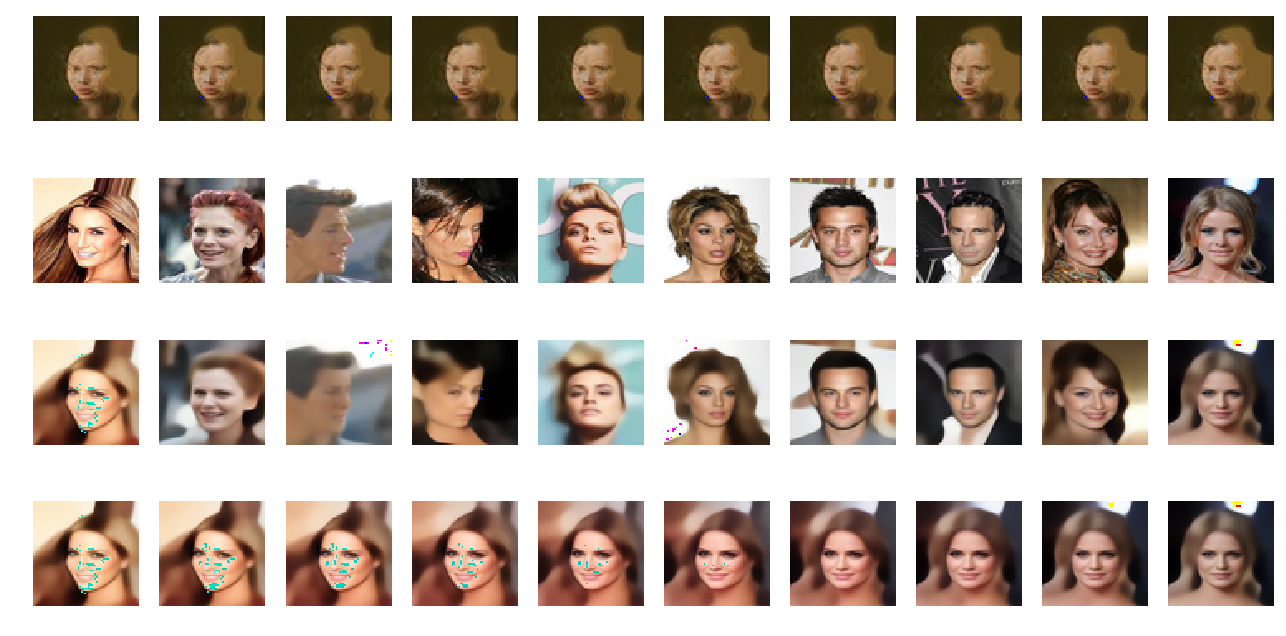

Epoch: 20 [====================>] 202599/202599, loss: d=0.4861, g=0.8029

In [33]:
while epoch < epoch_size:
    d_loss = []
    g_loss = []
    
    batch_count = 0    
    status = ('start training')
    sys.stdout.write(status)
    sys.stdout.flush()
    
    
    shuffle_files = file_names[np.random.permutation(range(len(file_names)))]
    for i in range(count):
        s = i * batch_size
        e = s + batch_size
        
        batch_files = shuffle_files[s:e]
        batch_train = batch_from_dataset(batch_files, image_width, image_height)
        batch_train = batch_train.astype(np.float32) * 2 - 1
        batch_target = file_tags[s:e]
        batch_count += len(batch_train)
        
        batch_z_var = np.random.uniform(-1, 1, size=(len(batch_train), z_var)).astype(np.float32)
        batch_z_category = np.random.randint(0, 2, size=(len(batch_train), z_category))
                
        _, loss_d, loss_g = sess.run([Update_K, Loss_D, Loss_G], feed_dict={
                                X_Real: batch_train,
                                Y: batch_target,
                                Z_var: batch_z_var,
                                Z_category: batch_z_category
                            })
        
        d_loss += [loss_d]
        g_loss += [loss_g]
                        
        if (i+1) % display_count == 0:
            g_fake = sess.run(X_Fake, feed_dict={Z: z_sample})
            e_real, d_real = sess.run([E_Real, D_Real], feed_dict={X_Real: image_sample})
            left, right = e_real[[0, -1]]
            interpolate_z = []
            for ratio in np.linspace(0, 1, 10):
                interpolate_z.append(slerp(ratio, left, right))
            d_inter = sess.run(D_Inter, feed_dict={Z: interpolate_z})

            display.clear_output(wait=True)
            DisplayHorizontal([ArrayToImage((x * 0.5 + 0.5) * 255) for x in np.concatenate([g_fake, image_sample, d_real, d_inter], axis=0)], depth=4, figsize=(16, 8))
            print('Epoch: %d, Count: %d' % (epoch+1, i+1))
            display.display(plt.gcf())
            plt.savefig(sample_figure_path + 'info_BEGAN_2_epoch_%d_batch_%d.png' % (epoch+1, i+1))
            plt.close()
        else:
            sys.stdout.write('\r')
            sys.stdout.flush()
        status = (("Epoch: %d [%-" + str(display_with + 1) + "s] %d/%d, loss: d=%.4f, g=%.4f") %
          (epoch+1, '=' * int(batch_count / file_size * display_with) + '>', batch_count, file_size, np.mean(loss_d), np.mean(loss_g)))
        sys.stdout.write(status)
        sys.stdout.flush()
    
    sess.run(LR_Update)
    saver.save(sess, model_path + 'info_BEGAN_CelebA.ckpt')
    
    epoch += 1